In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
import matplotlib.pyplot as plt
import torch.optim as optim
import torchmetrics
import numpy as np
import random
import cv2

In [2]:
# Set the seed
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [3]:
# mean and sd for images size 299,299
mean = [0.1854, 0.1854, 0.1855]
std = [0.2005, 0.2005, 0.2005]

train_ratio = 0.8 # train, valid split
batch_size = 32
epochs = 10
lr = 1e-5

# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
data_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [5]:
# Load the datasets
train_dataset = datasets.ImageFolder(root="../data/Training", transform=data_transform)
test_dataset = datasets.ImageFolder(root="../data/Testing", transform=data_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Split Train into Train, Valid
train_size = int(train_ratio * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
# Initialize Inception V3 Model
model = models.inception_v3(weights=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, len(train_dataset.classes))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

c:\Users\jesdi\.conda\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# summary(model, input_size=(1, 3, 299, 299))

In [8]:
auc_metric = torchmetrics.AUROC(task="multiclass", num_classes=len(train_dataset.classes)).to(device)
confusion_matrix_metric = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

In [9]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    train_loss, train_auc, val_loss, val_auc = [], [], [], []
    best_val_loss = float('inf') 
    
    for epoch in range(num_epochs):
        model.train()
        loss = 0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Clear previous gradients
            optimizer.zero_grad()
            
            # Inception v3 has two outputs: primary and auxiliary
            outputs, aux_outputs = model(images)  
            # calculate weighted loss
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            _loss = loss1 + 0.4 * loss2
            
            # Backpropagate and update weights
            _loss.backward()  
            optimizer.step()
            
            loss += _loss.item()
            
            # Get predicted class
            _, preds = outputs.max(1)  
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()
            
            auc_metric.update(outputs, labels)
            
        epoch_loss = loss / len(train_loader)
        accuracy = 100 * correct / total
        train_loss.append(epoch_loss)
        train_auc.append(auc_metric.compute().item())
        auc_metric.reset()
        
        # Validation Phase
        model.eval()
        loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _loss = criterion(outputs, labels)
                
                loss += _loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                
                # inceptionv3 returns logits. Thus convert to prob
                auc_metric.update(torch.nn.functional.softmax(outputs, dim=1), labels)
        
        val_epoch_loss = loss / len(val_loader)
        val_accuracy = 100 * correct / total
        val_loss.append(val_epoch_loss)
        val_auc.append(auc_metric.compute().item())
        auc_metric.reset()
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Train Acc: {accuracy:.2f} - Val Loss: {val_epoch_loss:.4f} - Val Accuracy: {val_accuracy:.2f}%")
        
        # Save model if validation loss is the lowest so far
        if val_epoch_loss < best_val_loss:
            # print(f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving model...")
            best_val_loss = val_epoch_loss
            torch.save(model.state_dict(), f'../models/inception_v3_{epoch}.pth')  # Save the model's parameters
    
    return train_loss, train_auc, val_loss, val_auc

In [10]:
# Train the model
train_loss, train_auc, val_loss, val_auc = train_model(model, train_loader, criterion, optimizer, num_epochs=epochs)

Epoch 1/10 - Train Loss: 2.1861 - Train Acc: 71.61 - Val Loss: 0.3933 - Val Accuracy: 90.90%
Epoch 2/10 - Train Loss: 0.5732 - Train Acc: 91.00 - Val Loss: 0.1985 - Val Accuracy: 94.49%
Epoch 3/10 - Train Loss: 0.2982 - Train Acc: 95.23 - Val Loss: 0.1318 - Val Accuracy: 95.98%
Epoch 4/10 - Train Loss: 0.1733 - Train Acc: 97.13 - Val Loss: 0.1028 - Val Accuracy: 96.68%
Epoch 5/10 - Train Loss: 0.1033 - Train Acc: 98.62 - Val Loss: 0.0897 - Val Accuracy: 97.38%
Epoch 6/10 - Train Loss: 0.0633 - Train Acc: 99.28 - Val Loss: 0.0837 - Val Accuracy: 97.46%
Epoch 7/10 - Train Loss: 0.0516 - Train Acc: 99.52 - Val Loss: 0.0717 - Val Accuracy: 97.73%
Epoch 8/10 - Train Loss: 0.0313 - Train Acc: 99.82 - Val Loss: 0.0752 - Val Accuracy: 97.90%
Epoch 9/10 - Train Loss: 0.0249 - Train Acc: 99.74 - Val Loss: 0.0743 - Val Accuracy: 97.73%
Epoch 10/10 - Train Loss: 0.0189 - Train Acc: 99.96 - Val Loss: 0.0761 - Val Accuracy: 97.90%


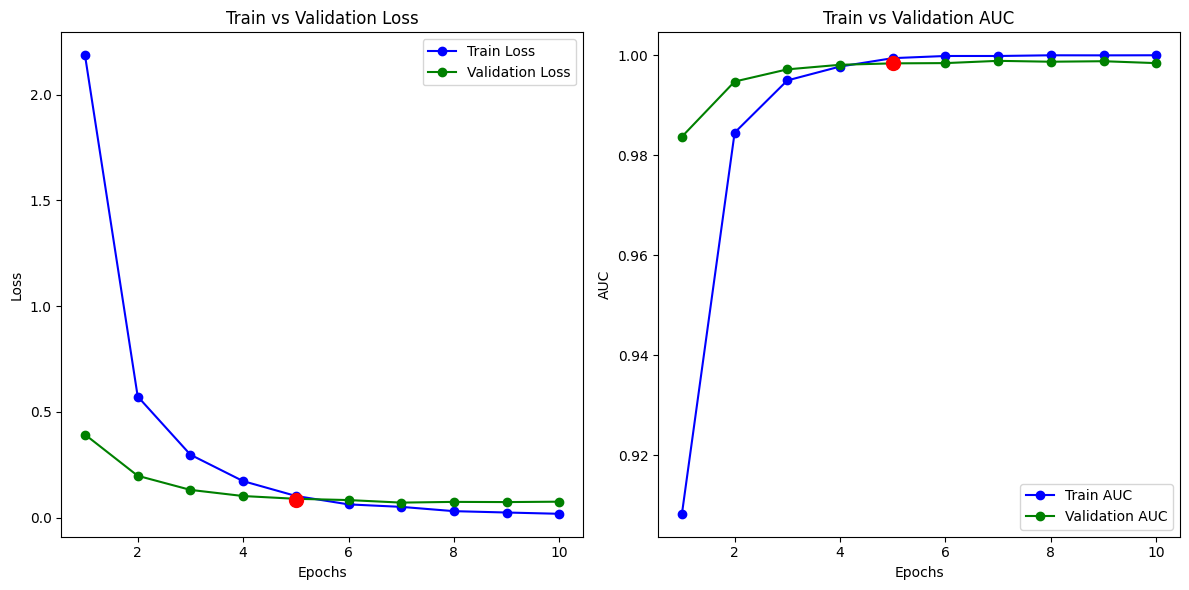

In [ ]:
epochs = range(1, epochs + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss", color='b', marker='o')
plt.plot(epochs, val_loss, label="Validation Loss", color='g', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.scatter(5, val_loss[5], color='r', s=100, zorder=5) 

plt.subplot(1, 2, 2)
plt.plot(epochs, train_auc, label="Train AUC", color='b', marker='o')
plt.plot(epochs, val_auc, label="Validation AUC", color='g', marker='o')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Train vs Validation AUC')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(5, val_auc[5], color='r', s=100, zorder=5) 

plt.tight_layout()
plt.show()

In [12]:
accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=len(test_dataset.classes)).to(device)
auc_metric = torchmetrics.AUROC(task="multiclass", num_classes=len(test_dataset.classes)).to(device)
confusion_matrix_metric = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=len(test_dataset.classes)).to(device)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        
        _, preds = torch.max(outputs, 1)

        accuracy_metric.update(preds, labels)

        auc_metric.update(torch.nn.functional.softmax(outputs, dim=1), labels)

        confusion_matrix_metric.update(outputs, labels)
final_accuracy = accuracy_metric.compute()
final_auc = auc_metric.compute()
final_confusion_matrix = confusion_matrix_metric.compute()

print(f"Test Accuracy: {final_accuracy:.4f}")
print(f"Test AUC: {final_auc:.4f}")
print(f"Confusion Matrix:\n{final_confusion_matrix}")

Test Accuracy: 0.9840
Test AUC: 0.9992
Confusion Matrix:
tensor([[287,  12,   0,   1],
        [  0, 302,   2,   2],
        [  0,   1, 404,   0],
        [  0,   3,   0, 297]], device='cuda:0')


In [13]:
def generate_saliency_map(model, image, label):
    # Enable gradient tracking for the input image
    image.requires_grad_()  

    output = model(image)

    # TODO: new images so no labels
    # _, predicted_label = torch.max(outputs, 1)
    output_class = output[0, label]

    # Backward pass to compute gradients
    model.zero_grad()
    output_class.backward()

    # Get the absolute value of the gradients (saliency map)
    saliency, _ = torch.max(image.grad.data.abs(), dim=1)

    return saliency

In [42]:
# Select a single image from the batch
image, label = [], []
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    image = images[0].unsqueeze(0)  # Add batch dimension (model expects image, batch)
    label = labels[0] 

    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


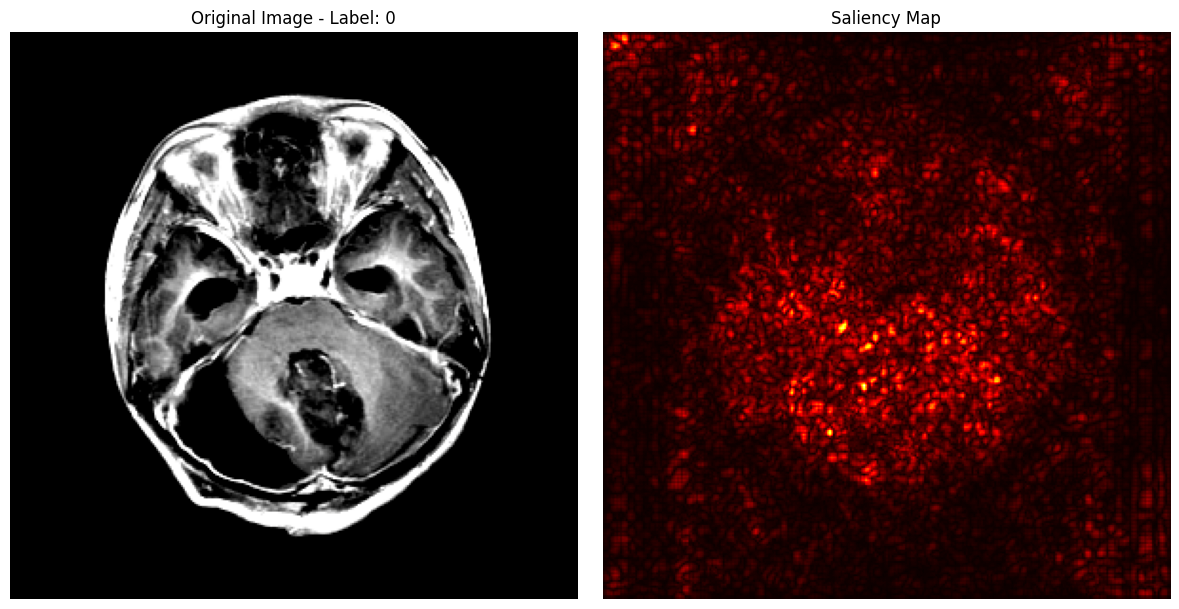

In [43]:
# Create a saliency map
saliency_map = generate_saliency_map(model, image, label)
saliency_map = saliency_map.squeeze().cpu().numpy()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display Original image
ax[0].imshow(image.squeeze().permute(1, 2, 0).detach().cpu().numpy())
ax[0].set_title(f"Original Image - Label: {label.item()}")
ax[0].axis("off")

# Display Saliency map
ax[1].imshow(saliency_map, cmap='hot')
ax[1].set_title(f"Saliency Map")
ax[1].axis("off")

plt.tight_layout()
plt.show()
    

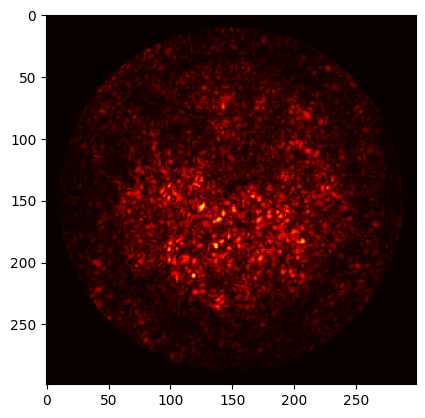

In [44]:
# Create a Circular Mask to focus on Brain
def create_circular_mask(h, w, center=None, radius=None):
    """Generate a circular mask to highlight the brain area."""
    if center is None:
        center = (int(w / 2), int(h / 2))
    if radius is None:
        radius = min(center[0], center[1], w - center[0], h - center[1]) - 10

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)
    mask = dist_from_center <= radius
    return mask

h, w = saliency_map.shape
circular_mask = create_circular_mask(h, w)
# remove areas outside the mask
saliency_map[~circular_mask] = 0
plt.imshow(saliency_map, cmap='hot')


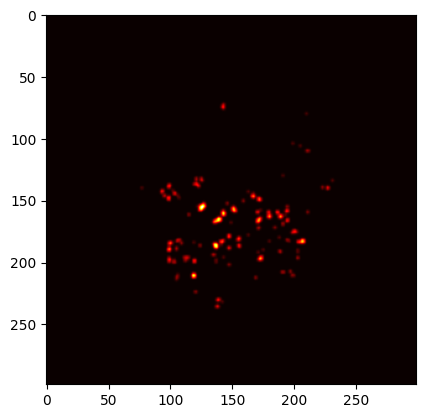

In [45]:
# Normalize
saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

# Apply threshold to highlight strong activations
threshold = 0.4
saliency_map[saliency_map < threshold] = 0

# Apply Gausian Smoothening
saliency_map = cv2.GaussianBlur(saliency_map, (5, 5), 0)
plt.imshow(saliency_map, cmap='hot')


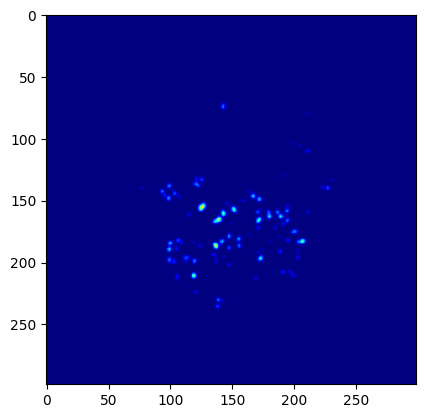

In [46]:
# Convert grayscale to heatmap using OpenCV
heatmap = cv2.applyColorMap(np.uint8(255 * saliency_map), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
plt.imshow(heatmap, cmap='hot')

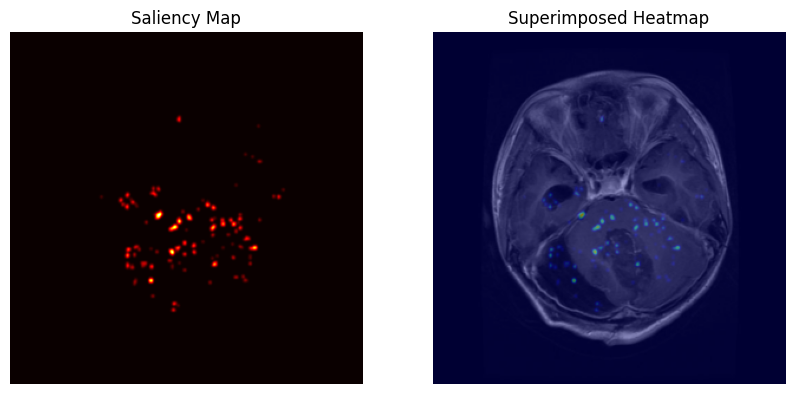

In [47]:
# Overlay on Original Image
heatmap = cv2.resize(heatmap, (w, h))

# Convert original tensor image to numpy
original_image = image.squeeze().permute(1, 2, 0).cpu().detach().numpy()
original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())
original_image = (original_image * 255).astype(np.uint8)

# Superimpose heatmap onto the original image
overlay = cv2.addWeighted(original_image, 0.6, heatmap, 0.4, 0)

# Show final result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Saliency Map")
plt.imshow(saliency_map, cmap="hot")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Superimposed Heatmap")
plt.imshow(overlay)
plt.axis("off")

plt.show()
